#**t-distributed Stochastic Neighbor Embedding(t-SNE)**

t-SNE (t-distributed Stochastic Neighbor Embedding) is an algorithm designed for the visualization of high-dimensional data sets.

This notebook performs a t-SNE (t-Distributed Stochastic Neighbor Embedding) analysis on antiviral compounds, grouped by target, using Morgan Chiral of radius 2. The goal is to visualize the chemical space of these compounds and identify patterns or clusters that might provide insights into their bioactivity and structural diversity.

Fingerprint used for this visualization: ECFP4

##**1. Prepare the environment**

In [ ]:
!pip install kaleido

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import MACCSkeys, AllChem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from scipy.spatial.distance import pdist
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Install rdkit
      !pip -q install rdkit.pypi==2021.9.4
      pbar.update(25)
      # Install molplotly
      !pip install molplotly
      pbar.update(50)
      # Install jupyter-dash
      !pip install jupyter-dash
      pbar.update(75)
      # Install el diseño de aplicación dash
      !pip install dash-bootstrap-components
      pbar.update(100)

  0%|          | 0/100 [00:00<?, ?it/s]

##**2. Load data set**

In [ ]:
antivirals_by_target = pd.read_csv("/content/combined_df_ACTIVE_05_11_24.csv")
antivirals_by_target

,Unnamed: 0,ID,main_organism,SMILES,DATASET,HBA,HBD,ROTBONDS,LOGP,TPSA,...,AROM_ATOMS,BASIC_ATOMS,BROMINE,CHLORINE,FLUORINE,IODINE,NITROGEN,OXYGEN,FRACROTBOND,CHIRALCENTERS
0,0,CHEMBL222813,influenza a virus,O=C(N[C@]1[C@]([C@](O)[C@](O)CO)OC(C(=O)O)=C[C...,IAV_Neuraminidase,7,8,6,-3.57583,198.220000,...,0,0,0,0,0,0,4,7,0.347826,5
1,1,CHEMBL1229,influenza a virus,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)OCC)C[C@@]1N)C,IAV_Neuraminidase,5,2,7,1.28540,90.650002,...,0,0,0,0,0,0,2,4,0.409091,3
2,2,CHEMBL674,influenza a virus,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)O)C[C@@]1N)C,IAV_Neuraminidase,4,3,6,0.80690,101.650000,...,0,0,0,0,0,0,2,4,0.350000,3
3,3,CHEMBL466246,influenza a virus,O=C(N[C@]1[C@]([C@](OC)[C@](O)CO)OC(C(=O)O)=C[...,IAV_Neuraminidase,7,7,7,-2.92173,187.220000,...,0,0,0,0,0,0,4,7,0.375000,5
4,4,CHEMBL467058,influenza a virus,O=C(OC[C@@](O)[C@@](OC)[C@]1[C@](NC(=O)C)[C@@]...,IAV_Neuraminidase,8,6,14,-0.01033,193.289990,...,0,0,0,0,0,0,4,8,0.515151,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,2197,DB00709,NaN,O=C1N([C@]2O[C@@](CO)SC2)C=CC(=N)N1,DB,6,3,2,-0.76373,91.099998,...,0,0,0,0,0,0,3,3,0.125000,2
2198,2198,DB00705,NaN,S(=O)(=O)(Nc1cc2c([nH]c(C(=O)N3CCN(c4c(NC(C)C)...,DB,6,3,6,2.71710,110.430000,...,15,0,0,0,0,0,6,3,0.200000,0
2199,2199,DB08864,NaN,N#CC=Cc1cc(C)c(N=C2NC(=Nc3ccc(C#N)cc3)NC=C2)c(...,DB,4,2,3,3.83290,103.880000,...,12,0,0,0,0,0,6,0,0.166667,0
2200,2200,DB03206,NaN,OC[C@@]1[C@@](O)[C@](O)[C@@](O)CN1,DB,5,5,1,-2.96680,92.949997,...,0,0,0,0,0,0,1,4,0.090909,4


In [ ]:
antivirals_by_target = antivirals_by_target[["ID", "SMILES", "DATASET"]]
antivirals_by_target

,ID,SMILES,DATASET
0,CHEMBL222813,O=C(N[C@]1[C@]([C@](O)[C@](O)CO)OC(C(=O)O)=C[C...,IAV_Neuraminidase
1,CHEMBL1229,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)OCC)C[C@@]1N)C,IAV_Neuraminidase
2,CHEMBL674,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)O)C[C@@]1N)C,IAV_Neuraminidase
3,CHEMBL466246,O=C(N[C@]1[C@]([C@](OC)[C@](O)CO)OC(C(=O)O)=C[...,IAV_Neuraminidase
4,CHEMBL467058,O=C(OC[C@@](O)[C@@](OC)[C@]1[C@](NC(=O)C)[C@@]...,IAV_Neuraminidase
...,...,...,...
2197,DB00709,O=C1N([C@]2O[C@@](CO)SC2)C=CC(=N)N1,DB
2198,DB00705,S(=O)(=O)(Nc1cc2c([nH]c(C(=O)N3CCN(c4c(NC(C)C)...,DB
2199,DB08864,N#CC=Cc1cc(C)c(N=C2NC(=Nc3ccc(C#N)cc3)NC=C2)c(...,DB
2200,DB03206,OC[C@@]1[C@@](O)[C@](O)[C@@](O)CN1,DB


##**3. Fingerprints generation**

In [ ]:
# Compute Morgan chrial radius 2 fingerprint
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fpSize = 2048, includeChirality = True)

In [ ]:
antivirals_by_target["fingerprint"] = antivirals_by_target["SMILES"].apply(lambda x: mfpgen.GetFingerprint(Chem.MolFromSmiles(x)))

<ipython-input-44-1a151d6ebada>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
antivirals_by_target

,ID,SMILES,DATASET,fingerprint
0,CHEMBL222813,O=C(N[C@]1[C@]([C@](O)[C@](O)CO)OC(C(=O)O)=C[C...,IAV_Neuraminidase,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,CHEMBL1229,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)OCC)C[C@@]1N)C,IAV_Neuraminidase,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL674,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)O)C[C@@]1N)C,IAV_Neuraminidase,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL466246,O=C(N[C@]1[C@]([C@](OC)[C@](O)CO)OC(C(=O)O)=C[...,IAV_Neuraminidase,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,CHEMBL467058,O=C(OC[C@@](O)[C@@](OC)[C@]1[C@](NC(=O)C)[C@@]...,IAV_Neuraminidase,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...
2197,DB00709,O=C1N([C@]2O[C@@](CO)SC2)C=CC(=N)N1,DB,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2198,DB00705,S(=O)(=O)(Nc1cc2c([nH]c(C(=O)N3CCN(c4c(NC(C)C)...,DB,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2199,DB08864,N#CC=Cc1cc(C)c(N=C2NC(=Nc3ccc(C#N)cc3)NC=C2)c(...,DB,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2200,DB03206,OC[C@@]1[C@@](O)[C@](O)[C@@](O)CN1,DB,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
antivirals_by_target.DATASET.unique()

array(['IAV_Neuraminidase', 'SARS-CoV-2_Mpro', 'IBV_Neuraminidase',
       'IAV_Polymerase (PA)', 'HRV_Protease', 'IAV_M2 proton channel',
       'SARS-CoV_Mpro', 'DB'], dtype=object)

In [ ]:
# Split fingerprint's column
data = []

for i in antivirals_by_target['fingerprint']:
  fp = i.ToBitString()
  data.append(list(fp))

fingerprint_df = pd.DataFrame(data)

# Reset the index of both DataFrames to ensure they align
antivirals_by_target = antivirals_by_target.reset_index(drop=True)
fingerprint_df = fingerprint_df.reset_index(drop=True)

# Concat the original DataFrame with the fingerprints one
result_df = pd.concat([antivirals_by_target[['ID', 'SMILES', 'DATASET']], fingerprint_df], axis=1)

result_df

,ID,SMILES,DATASET,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,CHEMBL222813,O=C(N[C@]1[C@]([C@](O)[C@](O)CO)OC(C(=O)O)=C[C...,IAV_Neuraminidase,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1229,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)OCC)C[C@@]1N)C,IAV_Neuraminidase,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL674,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)O)C[C@@]1N)C,IAV_Neuraminidase,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL466246,O=C(N[C@]1[C@]([C@](OC)[C@](O)CO)OC(C(=O)O)=C[...,IAV_Neuraminidase,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL467058,O=C(OC[C@@](O)[C@@](OC)[C@]1[C@](NC(=O)C)[C@@]...,IAV_Neuraminidase,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,DB00709,O=C1N([C@]2O[C@@](CO)SC2)C=CC(=N)N1,DB,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2198,DB00705,S(=O)(=O)(Nc1cc2c([nH]c(C(=O)N3CCN(c4c(NC(C)C)...,DB,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2199,DB08864,N#CC=Cc1cc(C)c(N=C2NC(=Nc3ccc(C#N)cc3)NC=C2)c(...,DB,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2200,DB03206,OC[C@@]1[C@@](O)[C@](O)[C@@](O)CN1,DB,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Train t-SNE model
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
data_tsne = result_df.copy()
data_tsne = data_tsne.drop(labels = ["DATASET", "ID","SMILES"],axis = 1)
data_tsne = StandardScaler().fit_transform(data_tsne)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_tsne)
tsne_results

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2202 samples in 0.080s...
[t-SNE] Computed neighbors for 2202 samples in 1.681s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2202
[t-SNE] Computed conditional probabilities for sample 2000 / 2202
[t-SNE] Computed conditional probabilities for sample 2202 / 2202
[t-SNE] Mean sigma: 15.945116
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.957771
[t-SNE] KL divergence after 300 iterations: 2.220751


array([[ 0.5314761 ,  0.73957783],
       [ 1.0387179 , -1.3886453 ],
       [ 0.15826972, -2.1709068 ],
       ...,
       [-0.01083441, -2.2349763 ],
       [ 2.921934  ,  0.07393523],
       [ 2.921934  ,  0.07393523]], dtype=float32)

In [ ]:
# Select complementary information
label = result_df[["DATASET", "ID", "SMILES"]]
label = label.to_numpy()
label.shape

(2202, 3)

In [ ]:
# Concatenar arrays de numpy
arr = np.concatenate((label, tsne_results), axis = 1)
arr.shape

(2202, 5)

In [ ]:
#  Create a new DataFrame
tsne_dataset = pd.DataFrame(data=arr, columns = ['DATASET',"ID", "SMILES",'axis 1', 'axis 2'] )
tsne_dataset.head(2)

,DATASET,ID,SMILES,axis 1,axis 2
0,IAV_Neuraminidase,CHEMBL222813,O=C(N[C@]1[C@]([C@](O)[C@](O)CO)OC(C(=O)O)=C[C...,0.531476,0.739578
1,IAV_Neuraminidase,CHEMBL1229,O=C(N[C@]1[C@](OC(CC)CC)C=C(C(=O)OCC)C[C@@]1N)C,1.038718,-1.388645


##**4. t-SNE Visualization**

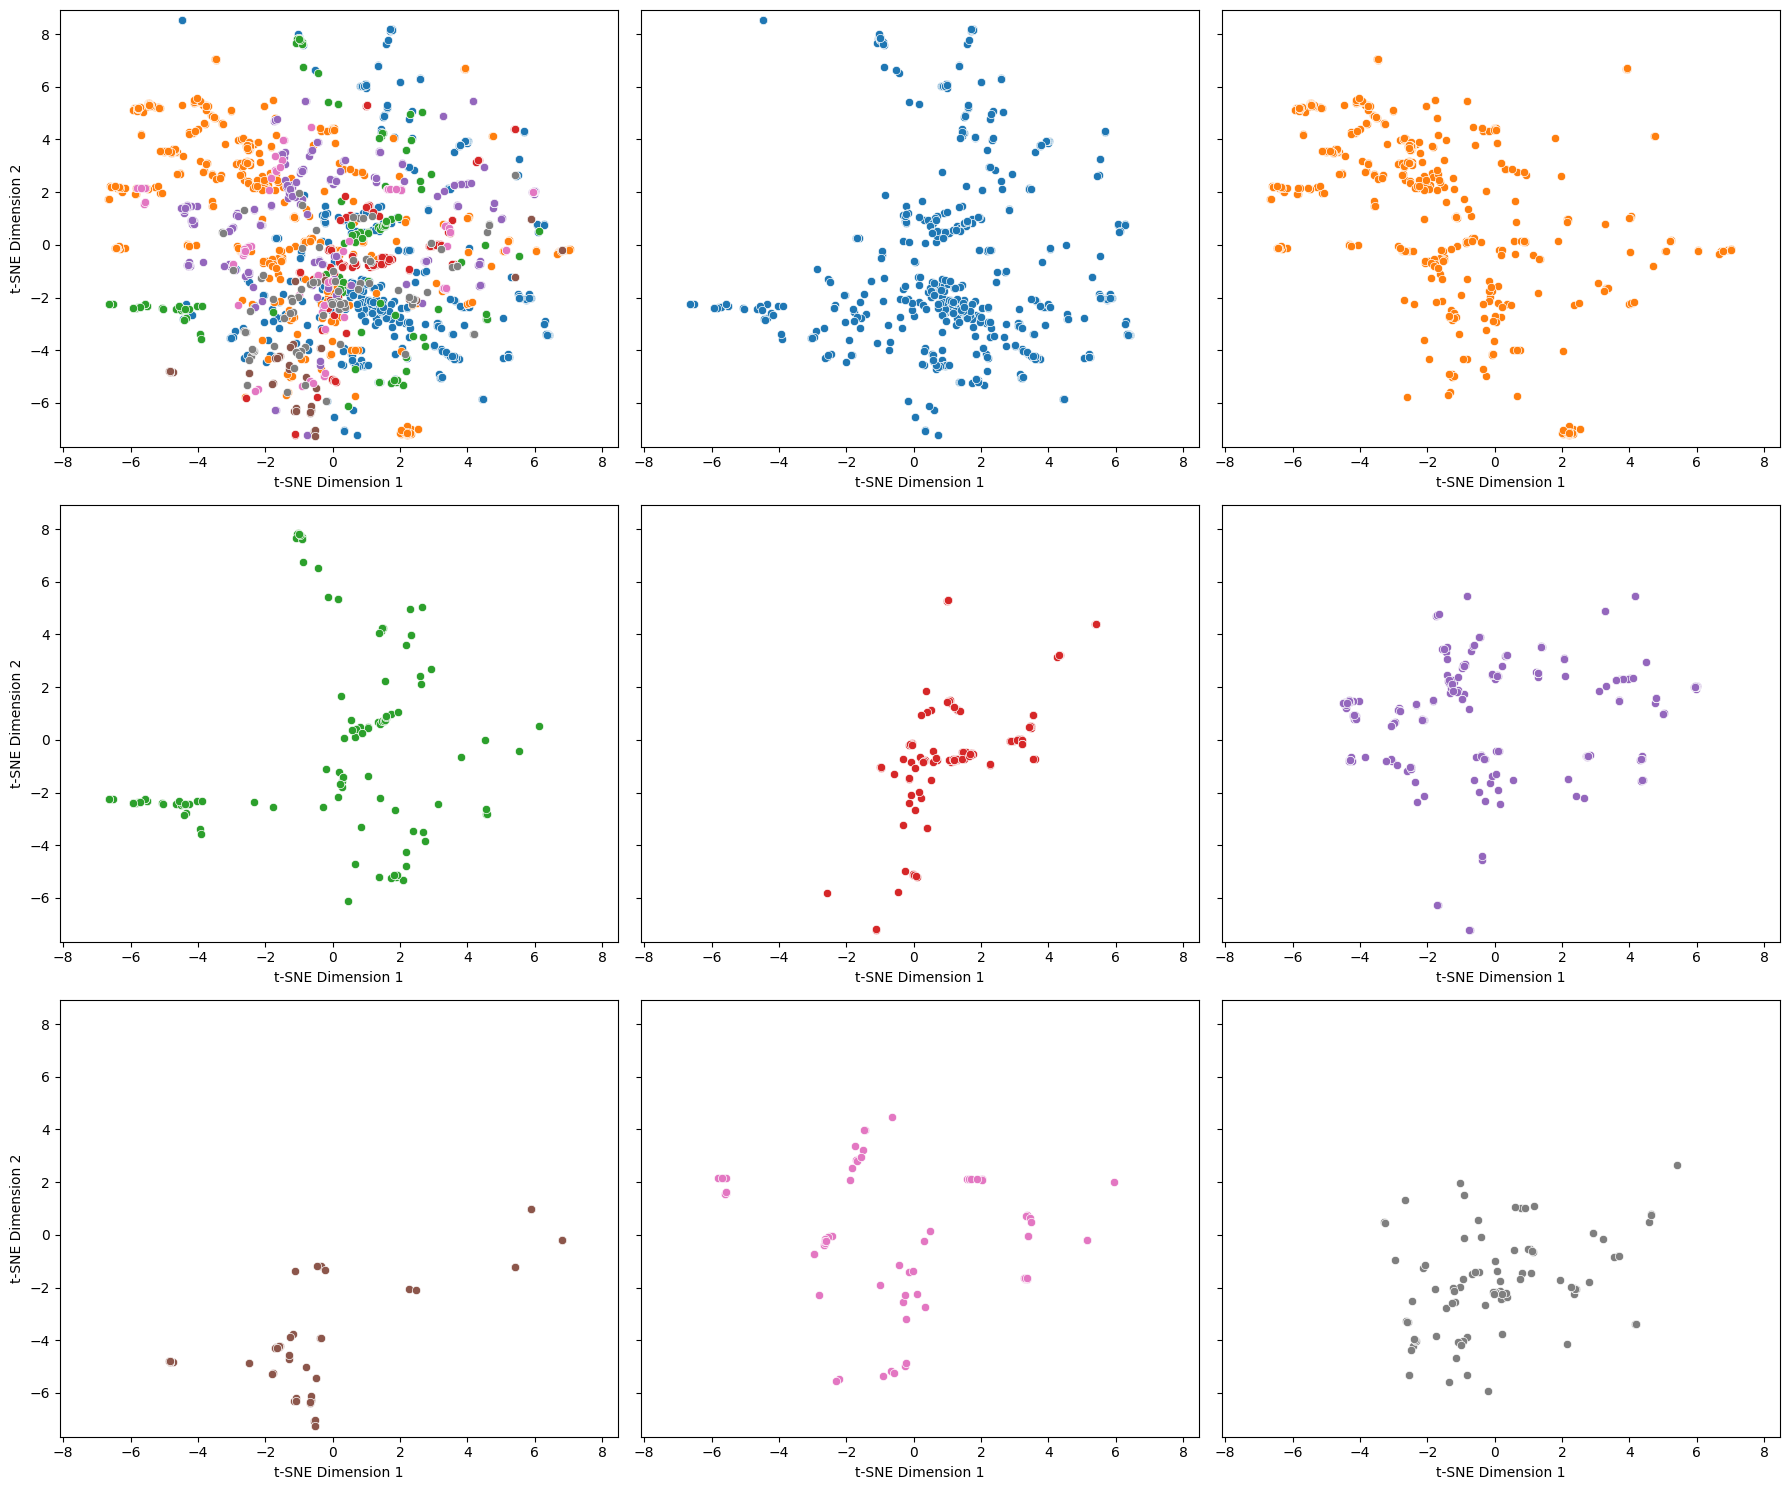

In [ ]:
# Obtain unique values from 'DATASET' column
unique_datasets = tsne_dataset['DATASET'].unique()

# Define a list of colors
color_discrete_sequence = ["#1f77b4", "#ff7f0e", '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Calculate global limits on x and y to ensure equal scaling with some extra margin
x_min, x_max = tsne_dataset['axis 1'].min(), tsne_dataset['axis 1'].max()
y_min, y_max = tsne_dataset['axis 2'].min(), tsne_dataset['axis 2'].max()

# Calculate a symmetrical range for both axes with a margin of 5%
margin = 0.05
x_range = (x_max - x_min) * (1 + margin)
y_range = (y_max - y_min) * (1 + margin)

# Ensure that both axles have the same length
range_max = max(x_range, y_range) / 2
center_x = (x_max + x_min) / 2
center_y = (y_max + y_min) / 2

x_lim = (center_x - range_max, center_x + range_max)
y_lim = (center_y - range_max, center_y + range_max)

# Adjust the number of subplots to match the number of datasets plus the combined plot
num_datasets = len(unique_datasets[:8])  # Number of datasets to graph individually
num_cols = min(num_datasets + 1, 3)  # 3 columns
num_rows = ((num_datasets + 1) + num_cols - 1) // num_cols  # Number of rows needed

# Create a figure with the correct number of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 5 * num_rows), sharey=True)

# Flatten the axes array if it is multidimensional
axes = axes.flatten() if num_datasets > 1 else [axes]

# Create the combined subplot without title or legend in the first position
for i, dataset in enumerate(unique_datasets):
    dataset_filtered = tsne_dataset[tsne_dataset['DATASET'] == dataset]
    color = color_discrete_sequence[i % len(color_discrete_sequence)]
    sns.scatterplot(x=dataset_filtered['axis 1'], y=dataset_filtered['axis 2'], ax=axes[0], color=color)

axes[0].set_xlim(x_lim)
axes[0].set_ylim(y_lim)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=10)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=10)

# Iterate over unique DATASETS for individual subplots
for i, dataset in enumerate(unique_datasets[:8]):
    dataset_filtered = tsne_dataset[tsne_dataset['DATASET'] == dataset]
    color = color_discrete_sequence[i % len(color_discrete_sequence)]

    # Create the scatterplot in the corresponding untitled subplot
    sns.scatterplot(x=dataset_filtered['axis 1'], y=dataset_filtered['axis 2'], ax=axes[i + 1], color=color)
    axes[i + 1].set_xlim(x_lim)
    axes[i + 1].set_ylim(y_lim)
    axes[i + 1].set_xlabel('t-SNE Dimension 1', fontsize=10)
    if (i + 1) % num_cols == 0:  # Add y label only to the first chart in each row
        axes[i + 1].set_ylabel('t-SNE Dimension 2', fontsize=10)

# Remove any additional axes if not all subplots were used
for j in range(i + 2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Save figure
plt.savefig('tsne_visualization_ECFP4_actives_2.png', dpi=600)

plt.show()